In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import nltk

nltk.download("gutenberg")

[nltk_data] Downloading package gutenberg to /home/vscode/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [51]:
import re
from pathlib import Path
from typing import Final, Sequence, TypeAlias

import lightgbm as lgb
import numpy as np
import pandas as pd
import shap
from IPython.display import display
from matplotlib import pyplot as plt
from nltk.corpus import gutenberg
from numpy.typing import NDArray
from pandas import DataFrame

from authorship_tool.types_ import AuthorColl4dStr, Doc3dStr, Para2dStr, Tag
from authorship_tool.util import dim_reshaper
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.ml import cv_trainer
from authorship_tool.util.ml import trainer as trainer
from authorship_tool.util.ml.model import (
    CrossValidationResult,
    CvGlobalExplanationData,
    LGBMSource,
    Score,
    ShapData,
    TrainingResult,
    dump,
    pred_crosstab,
)
from authorship_tool.util.path_util import GutenbergKFoldPaths, GutenbergPaths

In [52]:
np.seterr(divide="call")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [53]:
print(lgb.__version__)

4.3.0


In [54]:
for idx, file_id in enumerate(iterable=gutenberg.fileids()):
    print(f"#{idx+1}\t{file_id}")

#1	austen-emma.txt
#2	austen-persuasion.txt
#3	austen-sense.txt
#4	bible-kjv.txt
#5	blake-poems.txt
#6	bryant-stories.txt
#7	burgess-busterbrown.txt
#8	carroll-alice.txt
#9	chesterton-ball.txt
#10	chesterton-brown.txt
#11	chesterton-thursday.txt
#12	edgeworth-parents.txt
#13	melville-moby_dick.txt
#14	milton-paradise.txt
#15	shakespeare-caesar.txt
#16	shakespeare-hamlet.txt
#17	shakespeare-macbeth.txt
#18	whitman-leaves.txt


In [55]:
Author: TypeAlias = str
NumOfParas: TypeAlias = int

authors: set[Author] = {
    match.group(1)
    for file_id in gutenberg.fileids()
    if (match := re.search(r"^(.+?)-", file_id)) is not None
}

para_size_by_author: dict[Author, NumOfParas] = {}

for index, author in enumerate(authors):
    books_of_author: AuthorColl4dStr = [
        gutenberg.paras(fileids=file_id)
        for file_id in gutenberg.fileids()
        if author in file_id
    ]

    para_num: NumOfParas = len([para for paras in books_of_author for para in paras])
    para_size_by_author[author] = para_num

sorted_para_size_by_author: dict[Author, NumOfParas] = dict(
    sorted(para_size_by_author.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_author.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")

1:	bible - 24608 paragraphs
2:	austen - 5265 paragraphs
3:	chesterton - 4055 paragraphs
4:	edgeworth - 3726 paragraphs
5:	melville - 2793 paragraphs
6:	whitman - 2478 paragraphs
7:	shakespeare - 2372 paragraphs
8:	bryant - 1194 paragraphs
9:	carroll - 817 paragraphs
10:	blake - 284 paragraphs
11:	burgess - 266 paragraphs
12:	milton - 29 paragraphs


In [771]:
AUTHOR_A: Final[str] = "shakespeare"
AUTHOR_B: Final[str] = "bryant"
PARAGRAPH_INIT_INDEX: Final[int] = 10
PARAGRAPH_END_INDEX: Final[int] = 1194

In [772]:
books_a: AuthorColl4dStr = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_A in file_id
]

paras_a: Doc3dStr = [para for paras in books_a for para in paras][
    PARAGRAPH_INIT_INDEX:PARAGRAPH_END_INDEX
]

for para in paras_a[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_A}, {len(paras_a)} paragraphs\n")

Fla . But wherefore art not in thy Shop to day ? Why do ' st thou leade these men about the streets ? Cob . Truly sir , to weare out their shooes , to get my selfe into more worke . But indeede sir , we make Holyday to see Caesar , and to reioyce in his Triumph
Mur . Wherefore reioyce ? What Conquest brings he home ? What Tributaries follow him to Rome , To grace in Captiue bonds his Chariot Wheeles ? You Blockes , you stones , you worse then senslesse things : O you hard hearts , you cruell men of Rome , Knew you not Pompey many a time and oft ? Haue you climb ' d vp to Walles and Battlements , To Towres and Windowes ? Yea , to Chimney tops , Your Infants in your Armes , and there haue sate The liue - long day , with patient expectation , To see great Pompey passe the streets of Rome : And when you saw his Chariot but appeare , Haue you not made an Vniuersall shout , That Tyber trembled vnderneath her bankes To heare the replication of your sounds , Made in her Concaue Shores ? And do

In [773]:
books_b: AuthorColl4dStr = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_B in file_id
]

paras_b: Doc3dStr = [para for paras in books_b for para in paras][
    PARAGRAPH_INIT_INDEX:PARAGRAPH_END_INDEX
]

for para in paras_b[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_B}, {len(paras_b)} paragraphs\n")

" Who is there ?" she said .
The same soft little voice answered , " It ' s the Rain , and I want to come in !"
" No , you can ' t come in ," said the little Tulip .
Then it was very still for a long time . At last , there came a little rustling , whispering sound , all round the window : _rustle , whisper , whisper_ .
" Who is there ?" said the little Tulip .
" It ' s the Sunshine ," said a little , soft , cheery voice , " and I want to come in !"
" N -- no ," said the little Tulip , " you can ' t come in ." And she sat still again .
Pretty soon she heard the sweet little rustling noise at the keyhole .
" Who is there ?" she said .
" It ' s the Sunshine ," said the cheery little voice , " and I want to come in , I want to come in !"
" No , no ," said the little Tulip , " you cannot come in ."
By and by , as she sat so still , she heard _tap , tap , tap_ , and _rustle , whisper , rustle_ , up and down the window - pane , and on the door and at the keyhole .
" _Who is there ? _ " she sa

In [774]:
print(f"total: {len(paras_a + paras_b)} paragraphs (samples)")

total: 2368 paragraphs (samples)


In [775]:
all_paras: list[Para2dStr] = paras_a + paras_b

all_pos: list[Tag] = PosFeature(all_paras).tag_subcategories().all_pos

print(all_pos)

["''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_exp', 'JJ_lim', 'JJ_pp', 'JJ_presp', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']


In [776]:
dataset_generator = ParagraphFeatureDatasetGenerator(tags=all_pos)

In [777]:
para_ans_pairs: Sequence[tuple[Para2dStr, bool]] = [
    (para, True) for para in paras_a
] + [(para, False) for para in paras_b]

In [778]:
dataset_list: list[pd.Series] = [
    dataset_generator.generate_from_paragraph(para, answer)
    for para, answer in para_ans_pairs
]

In [779]:
dataset: DataFrame = pd.concat(dataset_list, axis=1).reset_index(drop=True).T

In [780]:
dataset.columns = (*dataset_generator.columns, "answer")
for col, dtype in zip(
    dataset.columns,
    dataset_generator.dtypes + [bool],
    strict=True,
):
    dataset[col] = dataset[col].astype(dtype)

In [781]:
display(dataset.head(10))

,EX,FW,IN,JJ,JJR,JJS,JJ_exp,JJ_lim,JJ_pp,JJ_presp,NN,NNP,NNPS,NNS,PDT,POS,SYM,UH,WDT,WP,WP$,WRB,answer
0,0.0,0.0,0.066667,0.066667,0.016667,0.000000,0.0,0.0,0.0,0.0,0.100000,0.083333,0.000000,0.066667,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.016667,True
1,0.0,0.0,0.065421,0.042056,0.000000,0.004673,0.0,0.0,0.0,0.0,0.079439,0.140187,0.009346,0.060748,0.000000,0.0,0.000000,0.0,0.0,0.009346,0.0,0.004673,True
2,0.0,0.0,0.081633,0.040816,0.000000,0.020408,0.0,0.0,0.0,0.0,0.081633,0.163265,0.000000,0.081633,0.020408,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,True
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.000000,0.166667,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,True
4,0.0,0.0,0.086957,0.021739,0.000000,0.021739,0.0,0.0,0.0,0.0,0.108696,0.043478,0.000000,0.021739,0.000000,0.0,0.021739,0.0,0.0,0.000000,0.0,0.021739,True
5,0.0,0.0,0.066667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.266667,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,True
6,0.0,0.0,0.094595,0.027027,0.000000,0.000000,0.0,0.0,0.0,0.0,0.108108,0.108108,0.000000,0.040541,0.000000,0.0,0.000000,0.0,0.0,0.013514,0.0,0.013514,True
7,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,True
8,0.0,0.0,0.064516,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.032258,0.419355,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,True
9,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.666667,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,True


In [782]:
print(dataset.shape)

(2368, 23)


In [783]:
print(dataset.dtypes)

EX          float64
FW          float64
IN          float64
JJ          float64
JJR         float64
JJS         float64
JJ_exp      float64
JJ_lim      float64
JJ_pp       float64
JJ_presp    float64
NN          float64
NNP         float64
NNPS        float64
NNS         float64
PDT         float64
POS         float64
SYM         float64
UH          float64
WDT         float64
WP          float64
WP$         float64
WRB         float64
answer         bool
dtype: object


In [784]:
print(dataset.isna().sum())

EX          0
FW          0
IN          0
JJ          0
JJR         0
JJS         0
JJ_exp      0
JJ_lim      0
JJ_pp       0
JJ_presp    0
NN          0
NNP         0
NNPS        0
NNS         0
PDT         0
POS         0
SYM         0
UH          0
WDT         0
WP          0
WP$         0
WRB         0
answer      0
dtype: int64


In [785]:
df: DataFrame = dataset.iloc[:, :-1]
nd_category: NDArray = dataset.iloc[:, -1].to_numpy(dtype=np.bool_)

In [786]:
source: LGBMSource = LGBMSource(feature_data_frame=df, nd_category=nd_category)
result: TrainingResult = trainer.train_once(source)

[LightGBM] [Info] Number of positive: 942, number of negative: 952
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1756
[LightGBM] [Info] Number of data points in the train set: 1894, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497360 -> initscore=-0.010560
[LightGBM] [Info] Start training from score -0.010560


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [787]:
score: Score | None = result.score

In [788]:
if score is not None:
    print(f"auc-roc score: {score.auc_roc_score}")
    print(f"f1 score: {score.f1_score}")
    print(f"accuracy score: {score.accuracy_score}")

auc-roc score: 0.8694428612140211
f1 score: 0.8
accuracy score: 0.7911392405063291


In [789]:
display(pred_crosstab(result.splitted_dataset.test_ans, result.prediction.pred_ans))

predicted,False,True
actual,,
False,177,55
True,44,198


In [790]:
dump(result, GutenbergPaths)

In [791]:
FIRST_DATA_INDEX: Final[int] = 0
shap_data: ShapData = result.shap_data
explainer: shap.Explainer = shap_data.explainer

local_explanation = shap.Explanation(
    base_values=shap_data.base_values,
    values=shap_data.shap_values[FIRST_DATA_INDEX],
    data=shap_data.data.to_numpy()[FIRST_DATA_INDEX],
    feature_names=shap_data.data.columns,
)

global_explanation = shap.Explanation(
    base_values=shap_data.base_values,
    values=shap_data.shap_values,
    data=shap_data.data.to_numpy(),
    feature_names=shap_data.data.columns,
)

In [792]:
shap.initjs()

In [793]:
SHAP_GUTENBERG_FIGURE_DIR: Path = GutenbergPaths.shap_figure_dir

<Figure size 640x480 with 0 Axes>

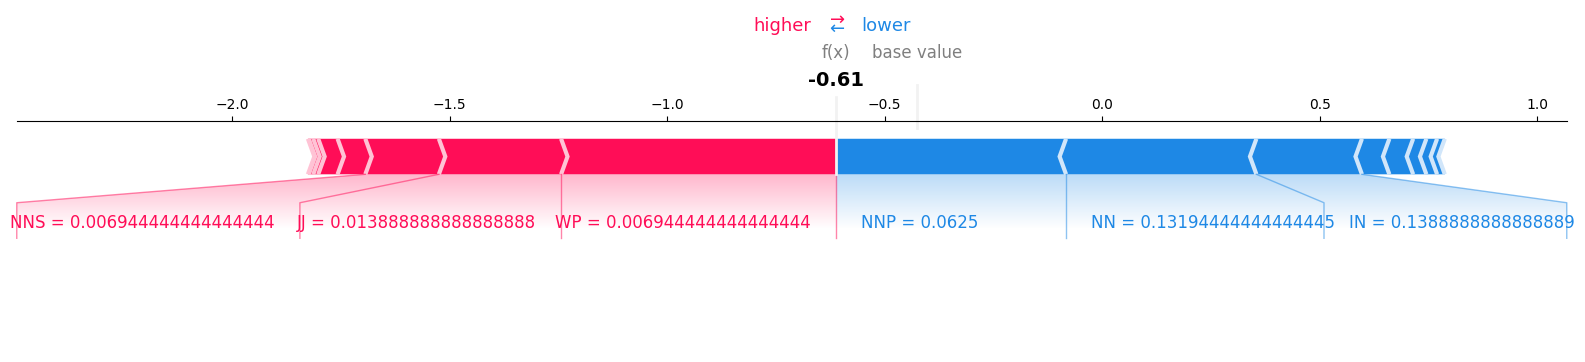

In [794]:
shap.plots.force(local_explanation)
shap.plots.force(
    local_explanation,
    matplotlib=True,
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_force_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

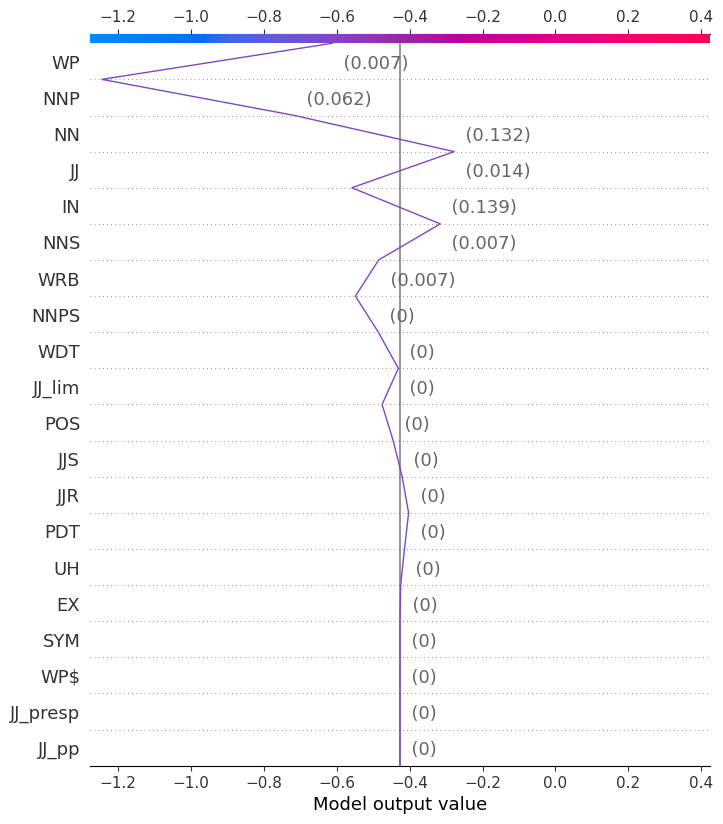

<Figure size 640x480 with 0 Axes>

In [795]:
shap.plots.decision(
    base_value=local_explanation.base_values,
    shap_values=local_explanation.values,
    features=local_explanation.data,
    feature_names=local_explanation.feature_names,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_decision_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

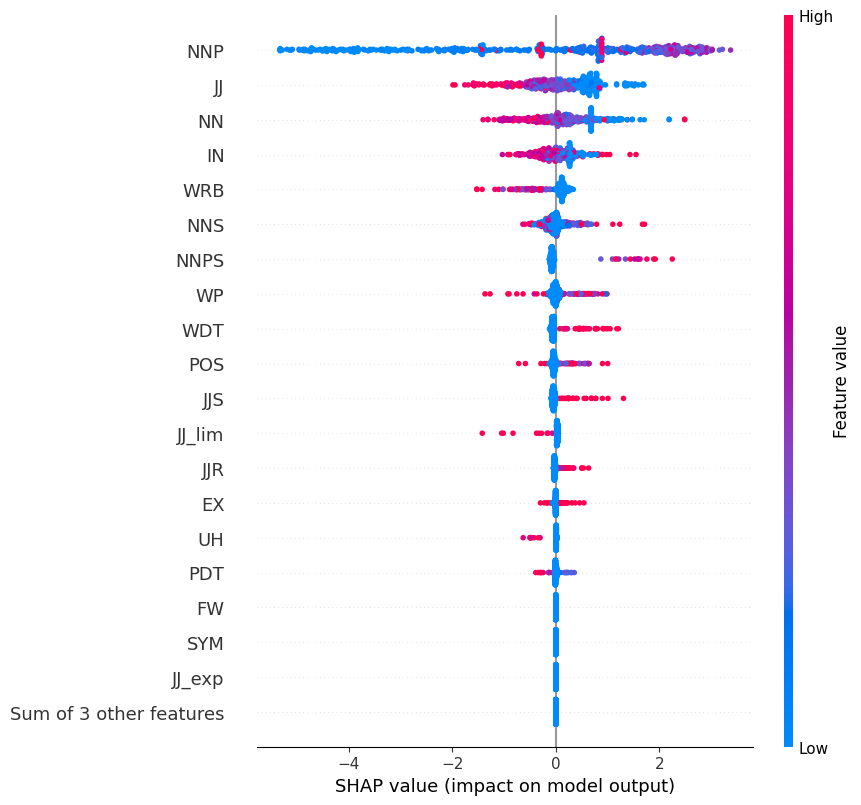

In [796]:
shap.plots.beeswarm(
    global_explanation,
    max_display=20,
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

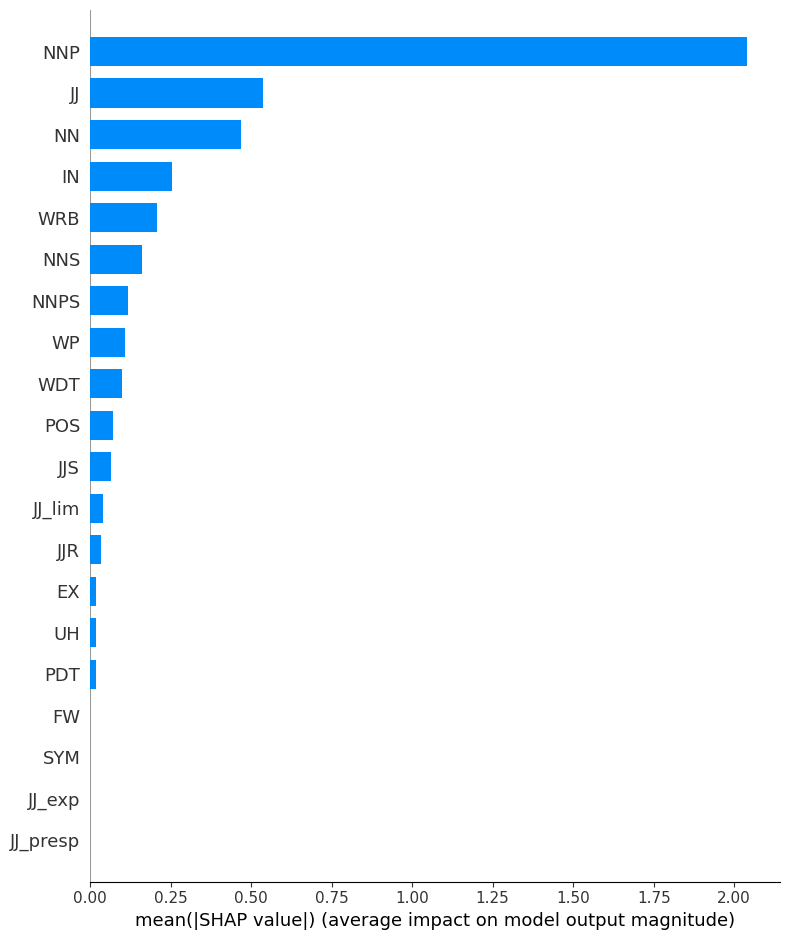

In [797]:
shap.summary_plot(
    global_explanation,
    plot_type="bar",
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

In [798]:
results_for_each_iters: list[TrainingResult] = cv_trainer.train_kfold(source, 100)

[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1842
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706
[LightGBM] [Info] Number of positive: 1175, number of negative: 1169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501280 -> initscore=0.005119
[LightGBM

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119
[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413
[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM]

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501280 -> initscore=0.005119
[LightGBM] [Info] Start training from score 0.005119
[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM]

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1167, number of negative: 1177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497867 -> initscore=-0.008532
[LightGBM] [Info] Start training from score -0.008532


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1176, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501706 -> initscore=0.006826
[LightGBM] [Info] Start training from score 0.006826


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119
[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1176, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501706 -> initscore=0.006826
[LightGBM] [Info] Start training from score 0.006826
[LightGBM] [Info] Number of positive: 1168, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498294 -> initscore=-0.006826
[LightGBM] [Info] Start training from score -0.006826


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1842
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413
[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1176, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501706 -> initscore=0.006826
[LightGBM] [Info] Start training from score 0.006826
[LightGBM] [Info] Number of positive: 1167, number of negative: 1177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497867 -> initscore=-0.008532
[LightGBM]

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1175, number of negative: 1169
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501280 -> initscore=0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1826
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413
[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413
[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1177, number of negative: 1167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502133 -> initscore=0.008532
[LightGBM] [Info] Start training from score 0.008532
[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706
[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1840
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706
[LightGBM] [Info] Number of positive: 1168, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498294 -> initscore=-0.006826
[LightGB

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1841
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706
[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1168, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498294 -> initscore=-0.006826
[LightGBM] [Info] Start training from score -0.006826


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1845
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706
[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM]

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413
[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1848
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706
[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1829
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1168, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498294 -> initscore=-0.006826
[LightGBM] [Info] Start training from score -0.006826
[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706
[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413
[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM]

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706
[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1176, number of negative: 1168
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1841
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501706 -> initscore=0.006826
[LightGBM] [Info] Start training from score 0.006826
[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] 

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1841
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413
[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706
[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501280 -> initscore=0.005119
[LightGBM] [Info] Start training from score 0.005119
[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1849
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413
[LightGBM] [Info] Number of positive: 1167, number of negative: 1178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497655 -> initscore=-0.009382
[LightGBM] [Info] Start training from score -0.009382


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559
[LightGBM] [Info] Number of positive: 1171, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499360 -> initscore=-0.002559
[LightGBM] [Info] Start training from score -0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1828
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498934 -> initscore=-0.004264
[LightGBM] [Info] Start training from score -0.004264
[LightGBM] [Info] Number of positive: 1173, number of negative: 1172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500213 -> initscore=0.000853
[LightGBM

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499787 -> initscore=-0.000853
[LightGBM] [Info] Start training from score -0.000853
[LightGBM] [Info] Number of positive: 1173, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500213 -> initscore=0.000853
[LightGBM] [Info] Start training from score 0.000853


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500213 -> initscore=0.000853
[LightGBM] [Info] Start training from score 0.000853
[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1846
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] [Info] Start training from score 0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499787 -> initscore=-0.000853
[LightGBM] [Info] Start training from score -0.000853
[LightGBM] [Info] Number of positive: 1176, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501493 -> initscore=0.005970
[LightGBM] [Info] Start training from score 0.005970


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] [Info] Start training from score 0.004264
[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1833
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498507 -> initscore=-0.005970
[LightGBM] [Info] Start training from score -0.005970
[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499360 -> initscore=-0.002559
[LightGBM] [Info] Start training from score -0.002559
[LightGBM] [Info] Number of positive: 1177, number of negative: 1168
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binar

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1835
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559
[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559
[LightGBM] [Info] Number of positive: 1169, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1836
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498507 -> initscore=-0.005970
[LightGBM] [Info] Start training from score -0.005970


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559
[LightGBM] [Info] Number of positive: 1170, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498934 -> initscore=-0.004264
[LightGBM] [Info] Start training from score -0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559
[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] 

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499787 -> initscore=-0.000853
[LightGBM] [Info] Start training from score -0.000853
[LightGBM] [Info] Number of positive: 1173, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500213 -> initscore=0.000853
[LightGBM] [Info] Start training from score 0.000853


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1841
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1830
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] [Info] Start training from score 0.004264
[LightGBM] [Info] Number of positive: 1173, number of negative: 1172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499360 -> initscore=-0.002559
[LightGBM] [Info] Start training from score -0.002559
[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] [Info] Start training from score 0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [799]:
cv_result: CrossValidationResult = cv_trainer.convert_results_to_cv_result(
    results_for_each_iters
)

In [800]:
cv_global_exp_data: CvGlobalExplanationData = (
    cv_trainer.convert_cv_result_to_global_exp_data(cv_result)
)

In [801]:
cv_score: Score = cv_trainer.calc_score_for_cv(cv_global_exp_data)

In [802]:
if cv_score is not None:
    print(f"auc-roc score:\t{cv_score.auc_roc_score}")
    print(f"f1 score:\t{cv_score.f1_score}")
    print(f"accuracy score:\t{cv_score.accuracy_score}")

auc-roc score:	0.873456688846786
f1 score:	0.7983367983367984
accuracy score:	0.7951858108108109


In [803]:
display(pred_crosstab(cv_global_exp_data.test_ans, cv_global_exp_data.pred_ans))

predicted,False,True
actual,,
False,923,261
True,224,960


In [804]:
test_data = cv_global_exp_data.test_data
shap_vals = cv_global_exp_data.shap_vals

cv_global_explanation = shap.Explanation(
    values=shap_vals,
    data=test_data,
)

In [805]:
shap.initjs()

In [806]:
gutenberg_kfold_figure_dir_path = GutenbergKFoldPaths.shap_figure_dir

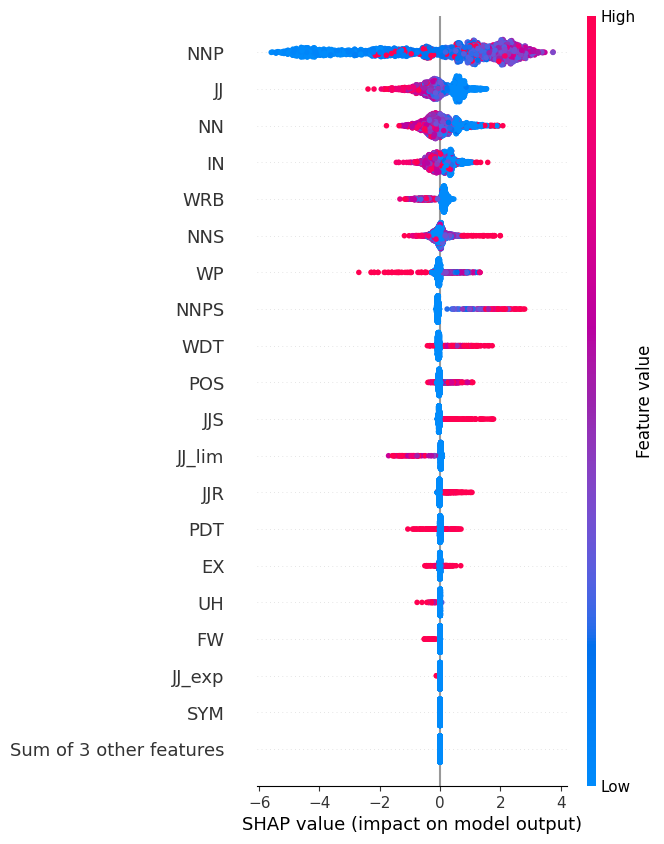

In [818]:
shap.plots.beeswarm(
    cv_global_explanation,
    max_display=20,
    show=False,
)

plt.savefig(
    gutenberg_kfold_figure_dir_path.joinpath("shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

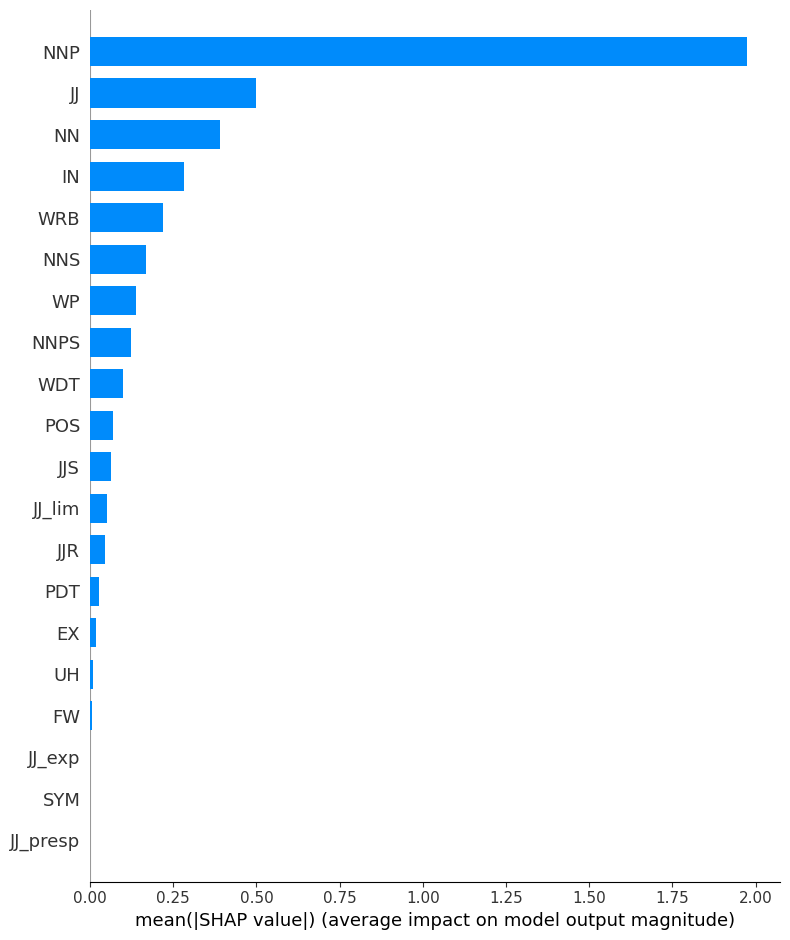

In [808]:
shap.summary_plot(
    cv_global_explanation,
    plot_type="bar",
    show=False,
)

plt.savefig(
    gutenberg_kfold_figure_dir_path.joinpath("shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()